Data loaded. Shape: (32561, 15)
Preprocessing completed:
X_train: (26029, 109)
X_test: (6508, 109)


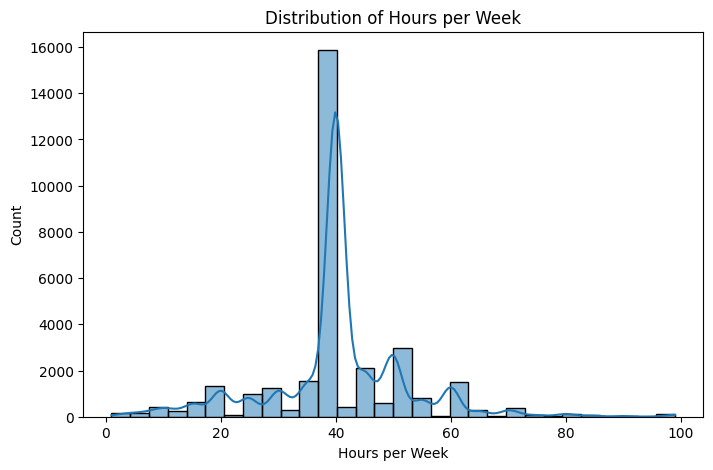

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32537.000000  3.253700e+04   32537.000000  32537.000000  32537.000000   
mean      38.585549  1.897808e+05      10.081815   1078.443741     87.368227   
std       13.637984  1.055565e+05       2.571633   7387.957424    403.101833   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.369930e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32537.000000  
mean        40.440329  
std         12.346889  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  
age               0
workclass         0
fnlwgt            0
edu

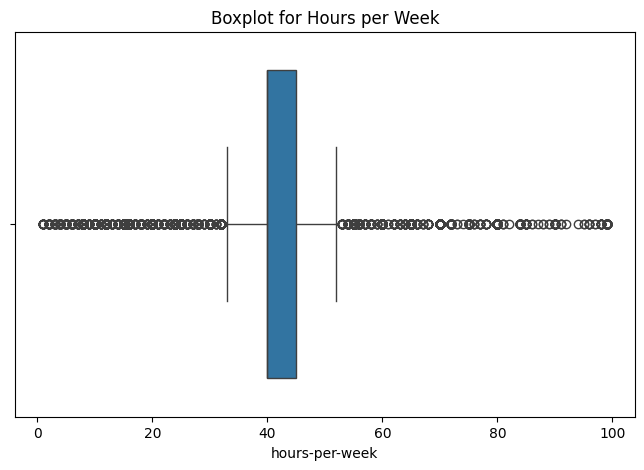

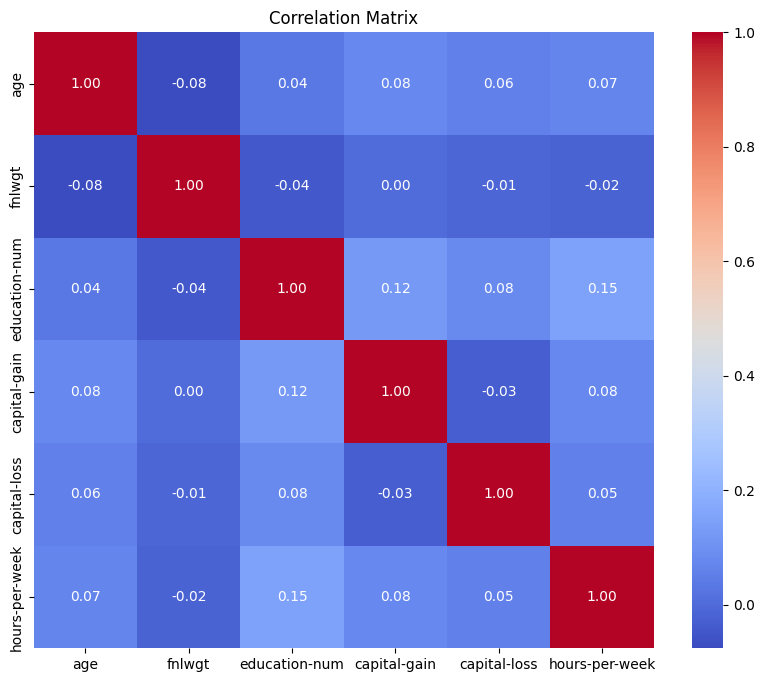

                   Model       MAE         MSE       RMSE        R2
0           SGDRegressor  7.698269  123.324373  11.105151  0.193744
1       LinearRegression  7.703644  123.170432  11.098218  0.194751
2  DecisionTreeRegressor  7.505323  122.884357  11.085322  0.196621
3  RandomForestRegressor  7.218028  112.288414  10.596623  0.265894


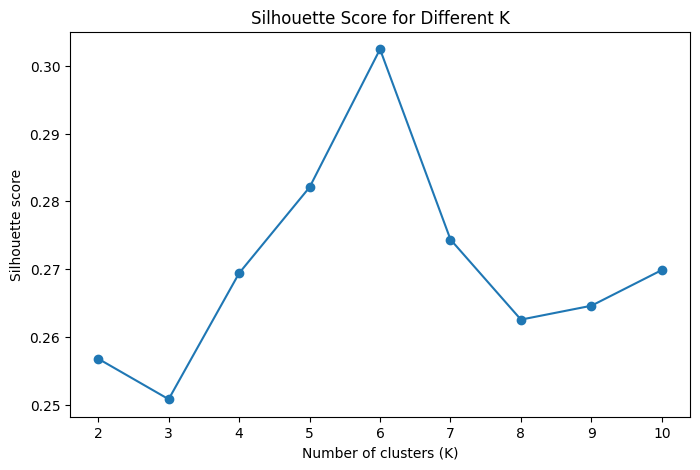

Optimal number of clusters: 6


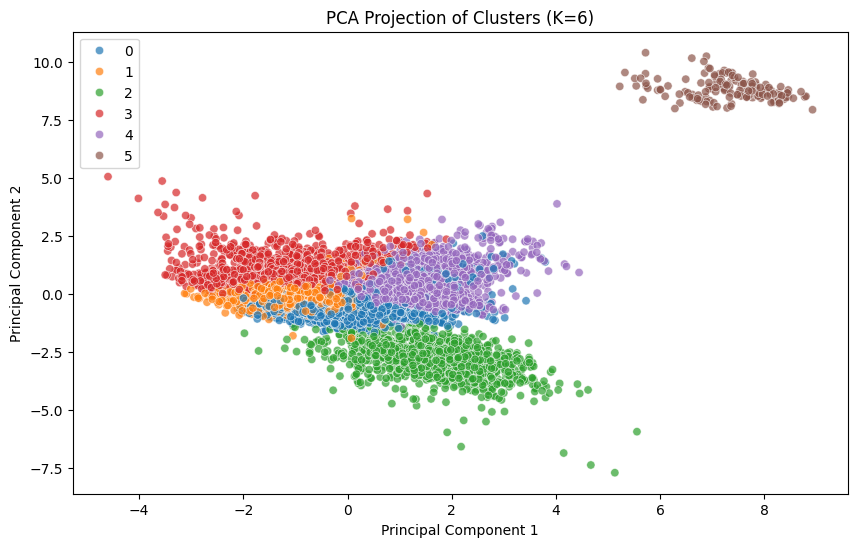

               age         fnlwgt  education-num  capital-gain  capital-loss
Cluster                                                                     
0        54.438393  160733.066031       8.494894    579.685092      0.896801
1        28.498173  153006.427756       8.979766    239.632231      0.309475
2        41.646662  185376.581929      10.987188      0.000000   1902.253540
3        33.552334  368688.629077       9.647623    487.169260      1.151354
4        40.492147  162646.871990      13.257592   1303.396728      0.811257
5        46.358491  192968.886792      12.918239  99999.000000      0.000000
Epoch 5/20, Loss: 80.9454
Epoch 10/20, Loss: 141.7199
Epoch 15/20, Loss: 187.4842
Epoch 20/20, Loss: 75.1209
{'MAE': 7.564197540283203, 'MSE': 120.66009521484375, 'RMSE': np.float64(10.98453891680683), 'R2': 0.21116238832473755}


In [1]:
# ===============================
# FINAL PROJECT – CENSUS DATA ANALYSIS
# Nadejda Galamaga
# ===============================

# ===============================
# TASK 0 – IMPORTS AND DATA LOADING
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(
    data_url,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

print("Data loaded. Shape:", data.shape)
data.head()

# The dataset contains demographic and employment-related variables.
# The target chosen for regression is hours-per-week.

# ===============================
# TASK 1 – PREPROCESSING
# ===============================

# Remove missing values
data.dropna(inplace=True)
# Only a small fraction of rows contained missing values, so dropping them should not distort the data.

# Remove duplicate rows
data.drop_duplicates(inplace=True)
# This avoids giving extra weight to repeated observations.

# Split features and target
X = data.drop("hours-per-week", axis=1)
y = data["hours-per-week"]

# Identify numerical and categorical columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing pipeline:
# - numeric variables are standardized
# - categorical variables are one-hot encoded
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_features)
    ]
)

X_prep = preprocessor.fit_transform(X)

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X_prep, y, test_size=0.2, random_state=42
)

print("Preprocessing completed:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# Preprocessed data is saved in case it needs to be reused later
pd.DataFrame(X_train.toarray()).to_csv("X_train_preprocessed.csv", index=False)
pd.DataFrame(X_test.toarray()).to_csv("X_test_preprocessed.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

# ===============================
# TASK 2 – EXPLORATORY DATA ANALYSIS
# ===============================

# Distribution of target variable
plt.figure(figsize=(8,5))
sns.histplot(data["hours-per-week"], bins=30, kde=True)
plt.title("Distribution of Hours per Week")
plt.xlabel("Hours per Week")
plt.ylabel("Count")
plt.show()

# The distribution peaks strongly around 40 hours/week, which matches a standard full-time schedule.
# There is a noticeable right tail, indicating a smaller group working significantly longer hours.

# Descriptive statistics
print(data.describe())

# Mean and median hours-per-week are very close, suggesting a fairly symmetric core distribution.
# Capital-gain and capital-loss show extreme values, which may influence some models.

# Missing values check
missing = data.isna().sum()
print(missing)

# After preprocessing, there are no missing values left in the dataset.

# Boxplot for outlier inspection
plt.figure(figsize=(8,5))
sns.boxplot(x=data["hours-per-week"])
plt.title("Boxplot for Hours per Week")
plt.show()

# A number of observations lie above the upper whisker.
# These represent individuals working unusually long hours rather than data errors.

# Correlation matrix
num_cols = data.select_dtypes(include=["int64", "float64"]).columns
corr = data[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Education level shows a moderate positive correlation with hours worked.
# Most other numerical variables have weak linear relationships with the target.

# ===============================
# TASK 3 – REGRESSION MODELS
# ===============================

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred)
    }

results = []

# SGD Regressor
sgd = SGDRegressor(max_iter=500, tol=1e-2, random_state=42)
sgd.fit(X_train, y_train)
results.append({
    "Model": "SGDRegressor",
    **evaluate(y_test, sgd.predict(X_test))
})

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
results.append({
    "Model": "LinearRegression",
    **evaluate(y_test, lr.predict(X_test))
})

# Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train.toarray(), y_train)
results.append({
    "Model": "DecisionTreeRegressor",
    **evaluate(y_test, dt.predict(X_test.toarray()))
})

# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=30,
    max_depth=10,
    random_state=42
)
rf.fit(X_train.toarray(), y_train)
results.append({
    "Model": "RandomForestRegressor",
    **evaluate(y_test, rf.predict(X_test.toarray()))
})

results_df = pd.DataFrame(results)
print(results_df)

# Linear models perform similarly, indicating limited linear signal.
# Tree-based models improve performance by capturing non-linear relationships.
# Random Forest achieves the highest R², though overall explanatory power remains moderate.

# ===============================
# TASK 4 – CLUSTERING
# ===============================

# Clustering is performed only on numerical features
X_num = data[num_features]
X_num_scaled = StandardScaler().fit_transform(X_num)

sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_num_scaled)
    sil_scores.append(silhouette_score(X_num_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score for Different K")
plt.show()

# The silhouette score suggests a moderate structure in the data.
# The best separation is achieved around the maximum of the curve.

optimal_k = K_range[np.argmax(sil_scores)]
print("Optimal number of clusters:", optimal_k)

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(X_num_scaled)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_num_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=clusters,
    palette="tab10",
    alpha=0.7
)
plt.title(f"PCA Projection of Clusters (K={optimal_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Clusters overlap in 2D space but still show grouping tendencies.
# This suggests gradual differences between groups rather than sharply separated segments.

cluster_summary = pd.DataFrame(X_num)
cluster_summary["Cluster"] = clusters
print(cluster_summary.groupby("Cluster").mean())

# Some clusters differ notably in age and education.
# Capital-gain and capital-loss vary strongly between clusters.

# ===============================
# TASK 5 – NEURAL NETWORK REGRESSION
# ===============================

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

nn_model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

epochs = 20
batch_size = 128

loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size,
    shuffle=True
)

for epoch in range(epochs):
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = nn_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Training loss decreases steadily, indicating the network is learning.
# Some fluctuation is expected due to mini-batch training.

nn_pred = nn_model(X_test_tensor).detach().numpy()
print(evaluate(y_test_tensor.numpy(), nn_pred))

# The neural network slightly improves error metrics compared to classical models.
# Further tuning (more epochs, different architecture) could potentially improve results.
